# Optimization and Initialization 

In [1]:
!conda info 



     active environment : DL-torch-arm64
    active env location : /Applications/anaconda3/envs/DL-torch-arm64
            shell level : 1
       user config file : /Users/antoineherbet/.condarc
 populated config files : /Users/antoineherbet/.condarc
          conda version : 24.7.1
    conda-build version : 24.5.1
         python version : 3.12.2.final.0
                 solver : libmamba (default)
       virtual packages : __archspec=1=m1
                          __conda=24.7.1=0
                          __osx=14.5=0
                          __unix=0=0
       base environment : /Applications/anaconda3  (writable)
      conda av data dir : /Applications/anaconda3/etc/conda
  conda av metadata url : None
           channel URLs : https://conda.anaconda.org/conda-forge/osx-arm64
                          https://conda.anaconda.org/conda-forge/noarch
                          https://repo.anaconda.com/pkgs/main/osx-arm64
                          https://repo.anaconda.com/pkgs/main/n

In [2]:
import torch
from torch import mps

# If Metal Performance Shader (mps) is not available tell me:
if not torch.backends.mps.is_available():
    if not torch.backends.mps.is_built():
        print("MPS not available because the current PyTorch install was not "
              "built with MPS enabled.")
    else:
        print("MPS not available because the current MacOS version is not 12.3+ "
              "and/or you do not have an MPS-enabled device on this machine.")

# If mps is available directly put it on the device.
else:
    device = torch.device("mps")
,
# If cuda (nvidia gpu) is not available tell me:
if not torch.cuda.is_available():
    print("Cuda not available because the current PyTorch install was not "
              "built with Cuda enabled.")
   

# If cuda is available directly put it on the device.
else:
    device = torch.device("cuda")
,

# Is mps available?

mps_avail = torch.backends.mps.is_available() 
print(f"Is Metal Performance Shader (mps) available? {mps_avail}")

,

# Is mps available?

cuda_avail = torch.cuda.is_available() 
print(f"Is Cuda available? {cuda_avail}")

Cuda not available because the current PyTorch install was not built with Cuda enabled.
Is Metal Performance Shader (mps) available? True
Is Cuda available? False


In this tutorial, we will review techniques for optimization and initialization of neural networks. When increasing the depth of neural networks, there are various challenges we face. Most importantly, we need to have a stable gradient flow through the network, as otherwise, we might encounter vanishing or exploding gradients. This is why we will take a closer look at the following concepts: initialization and optimization.

In the first half of the notebook, we will review different initialization techniques, and go step by step from the simplest initialization to methods that are nowadays used in very deep networks. In the second half, we focus on optimization comparing the optimizers SGD, SGD with Momentum, and Adam.

Let's start with importing our standard libraries:

In [3]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib_inline
%matplotlib inline
from IPython.display import set_matplotlib_formats
matplotlib_inline.backend_inline.set_matplotlib_formats('svg','pdf')
import seaborn as sns
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

We will use the same set_seed function as in Notebook 2, as weel as the path variables DATASET_PATH and CHECKPOINT_PATH.
Adjust the paths if necessary.

In [4]:
#  path to the folder where the datasets are/ should be downloaded (eg MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial4"

# function for setting the seed 
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.backends.mps.is_available(): # GPU operation have separate seeds
        torch.mps.manual_seed(seed)
 #       torch.mps.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproductibility
torch.backends.mps.deterministic=True
torch.backends.mps.benchmark=False

# Fetching the device that will be used throughout this notebook
# We already define a GPU device with mps before but if this notebook is launched on a Nvidia GPU:
#device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print(f"Using device : {device}")

Using device : mps


in the last part of the notebook, we will train models using different optimizers. The pretrained models for those are downloaded below:


In [5]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored for this tutorial
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial4/"
# Files to download
pretrained_files = ["FashionMNIST_SGD.config",    "FashionMNIST_SGD_results.json",    "FashionMNIST_SGD.tar",
                    "FashionMNIST_SGDMom.config", "FashionMNIST_SGDMom_results.json", "FashionMNIST_SGDMom.tar",
                    "FashionMNIST_Adam.config",   "FashionMNIST_Adam_results.json",   "FashionMNIST_Adam.tar"   ]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

## Préparation

Throughout this notebook, we will use a deep fully connected netword, similar to our previous notebook. We will also gain apply the network to FashionMNIST, so you can relate to the resultsts of Notebook 2. We start by loading the FashionMNIST dataset:

In [6]:
from torchvision.datasets import FashionMNIST
from torchvision import transforms

# transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1 
transform = transforms.Compose([ transforms.ToTensor(),
                               transforms.Normalize((0.2861,), (0.3530,)) # here is 2 paramaters for black and white)
                               ])                                         # we will calculate them just after

# loading the training dataset. We need to split into a training and validation part 
train_dataset = FashionMNIST(root=DATASET_PATH, train = True, transform=transform, download=True)
train_set , val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# load the test set:
test_set = FashionMNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# we define a set of data loaders that we can use for various purposes later.
# note that for actually training a model, we will use different data loaders
# with a lower batch size.

train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)


                               

In comparison to the previous notebook, we have changed the parameters of the normalization transformation transforms.Normalize. The normalization is now designed to give us an expected mean of 0 and a standard deviation of 1 across pixels. This will be particularly relevant for the discussion about initialization we will look at below, and hence we change it here. It should be noted that in most classification tasks, both normalization techniques (between -1 and 1 or mean 0 and stddev 1) have shown to work well. We can calculate the normalization parameters by determining the mean and standard deviation on the original images:

In [7]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.28604063391685486
Std 0.3530242443084717


We can verify the transformation by looking at the statistics of a single batch:

In [8]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard Deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Mimimum: {imgs.min().item():5.3f}")

Mean: 0.020
Standard Deviation: 1.011
Maximum: 2.022
Mimimum: -0.810


Note that the maximum and minimum are not 1 and -1 anymore, but shifted towards the positive values. This is because FashionMNIST contains a lot of black pixels, similar to MNIST.
Next, we create a linear neural network. We use the same setup as in the previous tutorial.

In [9]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[512, 256, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

For the activation functions, we make use of PyTorch's __torch.nn__ library instead of implementing ourselves. However, we also define an __Identity__ activation function. Although this activation function would significantly limit the network's modeling capabilities, we will use it in the first steps of our discussion about initialization (for simplicity). 

In [10]:
class Identity(nn.Module):
    def forward(self,x):
        return x 

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

Finally, we define a few plotting functions that we will use for our discussions. These functions help us to (1) visualize the weight/parameter distribution inside a network, (2) visualize the gradients that the parameters at different layers receive, and (3) the activations, i.e. the output of the linear layers. The detailed code is not important, but feel free to take a closer look if interested.

In [11]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

## Initialization 

Before starting our discussion about initialization, it should be noted that there exist many very good blog posts about the topic of neural network initialization (for example deeplearning.ai, or a more math-focused blog post). In case something remains unclear after this tutorial, we recommend skimming through these blog posts as well.

When initializing a neural network, there are a few properties we would like to have. First, the variance of the input should be propagated through the model to the last layer, so that we have a similar standard deviation for the output neurons. If the variance would vanish the deeper we go in our model, it becomes much harder to optimize the model as the input to the next layer is basically a single constant value. Similarly, if the variance increases, it is likely to explode (i.e. head to infinity) the deeper we design our model. The second property we look out for in initialization techniques is a gradient distribution with equal variance across layers. If the first layer receives much smaller gradients than the last layer, we will have difficulties in choosing an appropriate learning rate.

https://www.google.com/url?q=https%3A%2F%2Fwww.deeplearning.ai%2Fai-notes%2Finitialization%2F

As a starting point for finding a good method, we will analyze different initialization based on our linear neural network with no activation function (i.e. an identity). We do this because initializations depend on the specific activation function used in the network, and we can adjust the initialization schemes later on for our specific choice.

In [14]:
model = BaseNetwork(act_fn=Identity()).to(device) 

## Constant initialization 

The 1st initialization we can consider is to initialize all weights with the same constant value. Intuitively, setting all weights to zero is not a good idea as the propagated gradient will be zero. However, what happens if we set all weights to a value slightly larger or smaller than 0? To find out, we can implement a function for setting all parameters below and visualize the gradients. 

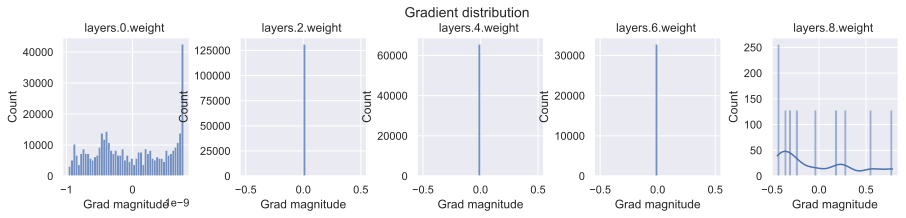

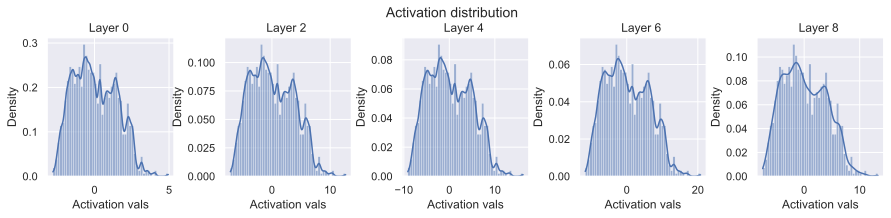

Layer 0 - Variance: 2.0582754611968994
Layer 2 - Variance: 13.489115715026855
Layer 4 - Variance: 22.100555419921875
Layer 6 - Variance: 36.209537506103516
Layer 8 - Variance: 14.831425666809082


In [15]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

As we can see, only the first and the last layer have diverse gradient distributions while the other three layers have the same gradient for all weights (note that this value is unequal 0, but often very close to it). Having the same gradient for parameters that have been initialized with the same values means that we will always have the same value for those parameters. This would make our layer useless and reduce our effective number of parameters to 1. Thus, we cannot use a constant initialization to train our networks.

## Constant variance
From the experiment above, we have seen that a constant value is not working. So instead, how about we initialize the parameters by randomly sampling from a distribution like a Gaussian? The most intuitive way would be to choose one variance that is used for all layers in the network. Let's implement it below, and visualize the activation distribution across layers.

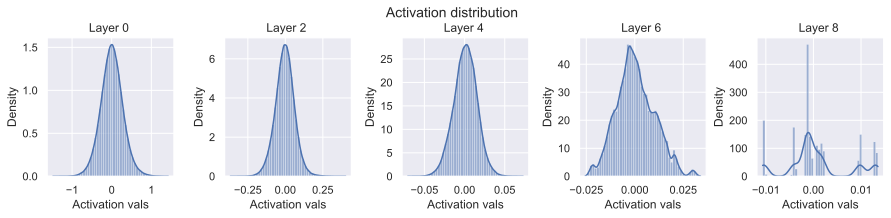

Layer 0 - Variance: 0.07771596312522888
Layer 2 - Variance: 0.00406030984595418
Layer 4 - Variance: 0.00020879440126009285
Layer 6 - Variance: 9.545486682327464e-05
Layer 8 - Variance: 3.965417272411287e-05


In [16]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

The variance of the activation becomes smaller and smaller across layers, and almost vanishes in the last layer. Alternativaly, we could use a higher standard deviation:

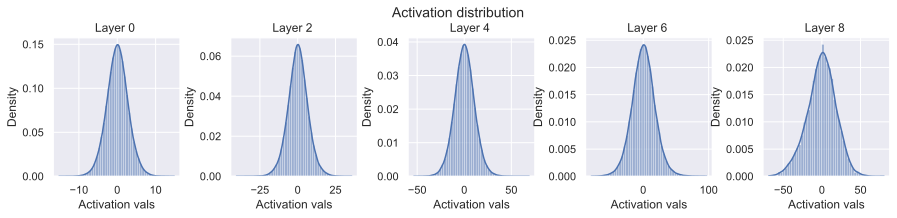

Layer 0 - Variance: 7.925612926483154
Layer 2 - Variance: 43.7206916809082
Layer 4 - Variance: 113.83341979980469
Layer 6 - Variance: 312.201416015625
Layer 8 - Variance: 347.9195861816406


In [17]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

With a higher standard deviation, the activations are likely to explode. You can play around with the specific standard deviation values, but it will be hard to find one that gives us a good activation distribution across layers and is very specific to our model. If we would change the hidden sizes or number of layers, you would have to search all over again, which is neither efficient nor recommended.

How to find appropriate initialization values
From our experiments above, we have seen that we need to sample the weights from a distribution, but are not sure which one exactly. As a next step, we will try to find the optimal initialization from the perspective of the activation distribution. For this, we state two requirements:

The mean of the activations should be zero
The variance of the activations should stay the same across every layer
Suppose we want to design an initialization for the following layer: 𝑦=𝑊𝑥+𝑏 with 𝑦∈ℝ𝑑𝑦, 𝑥∈ℝ𝑑𝑥. Our goal is that the variance of each element of 𝑦 is the same as the input, i.e. Var(𝑦𝑖)=Var(𝑥𝑖)=𝜎2𝑥, and that the mean is zero. We assume 𝑥 to also have a mean of zero, because, in deep neural networks, 𝑦 would be the input of another layer. This requires the bias and weight to have an expectation of 0. Actually, as 𝑏 is a single element per output neuron and is constant across different inputs, we set it to 0 overall.

Next, we need to calculate the variance with which we need to initialize the weight parameters. Along the calculation, we will need the following variance rule: given two independent variables, the variance of their product is Var(𝑋⋅𝑌)=𝔼(𝑌)2Var(𝑋)+𝔼(𝑋)2Var(𝑌)+Var(𝑋)Var(𝑌)=𝔼(𝑌2)𝔼(𝑋2)−𝔼(𝑌)2𝔼(𝑋)2 (𝑋 and 𝑌 are not refering to 𝑥 and 𝑦, but any random variable).

The needed variance of the weights, Var(𝑤𝑖𝑗), is calculated as follows:

𝑦𝑖Var(𝑦𝑖)=𝜎2𝑥⇒Var(𝑤𝑖𝑗)=𝜎2𝑊=∑𝑗𝑤𝑖𝑗𝑥𝑗Calculation of a single output neuron without bias=Var(∑𝑗𝑤𝑖𝑗𝑥𝑗)=∑𝑗Var(𝑤𝑖𝑗𝑥𝑗)Inputs and weights are independent of each other=∑𝑗Var(𝑤𝑖𝑗)⋅Var(𝑥𝑗)Variance rule (see above) with expectations being zero=𝑑𝑥⋅Var(𝑤𝑖𝑗)⋅Var(𝑥𝑗)Variance equal for all 𝑑𝑥 elements=𝜎2𝑥⋅𝑑𝑥⋅Var(𝑤𝑖𝑗)=1𝑑𝑥

Thus, we should initialize the weight distribution with a variance of the inverse of the input dimension 𝑑𝑥. Let's implement it below and check whether this holds: